# **Forecasting-Multivariate-Multistep**

## Prediksi Timeseries Kecepatan Angin Multi-Step



*   Nama : Zulfa Lailatul Mu'achirin
*   Nim : 220411100147
*   Matkul : PSD D

## Data Understanding

Prediksi kecepatan angin dengan presisi tinggi dan keandalan yang baik adalah tantangan bagi para ahli meteorologi. Angin kencang akibat badai konvektif menyebabkan kerusakan yang signifikan (kerusakan hutan skala besar, pemadaman listrik, kerusakan bangunan/rumah, dll.). Peristiwa konvektif seperti badai petir, tornado, serta hujan es besar dan angin kencang merupakan bahaya alam yang berpotensi mengganggu kehidupan sehari-hari, terutama di daerah dengan medan yang kompleks yang mendukung terjadinya konveksi. Bahkan peristiwa konvektif biasa dapat menghasilkan angin kencang yang menyebabkan kerusakan fatal dan mahal. Oleh karena itu, prediksi kecepatan angin adalah tugas penting untuk memberikan peringatan dini tentang cuaca ekstrem. Dataset ini berisi respons dari sensor cuaca yang mengumpulkan berbagai variabel cuaca seperti suhu dan curah hujan.

Dataset berasal dari kaggle https://www.kaggle.com/datasets/fedesoriano/wind-speed-prediction-dataset, yang memiliki 9 fitur. Berisi 6.574 data harian rata-rata yang berasal dari lima sensor variabel cuaca yang terintegrasi di sebuah stasiun meteorologi. Perangkat ini ditempatkan di area terbuka yang cukup kosong pada ketinggian 21 meter. Data dicatat dari Januari 1961 hingga Desember 1978 (selama 17 tahun). **Ground truth** berupa rata-rata harian presipitasi, suhu maksimum dan minimum, serta suhu minimum rumput juga disediakan.



### Informasi Atribut
1. **DATE**: Tanggal (YYYY-MM-DD)  
2. **WIND**: Kecepatan angin rata-rata (knots)  
3. **IND**: Nilai indikator pertama  
4. **RAIN**: Jumlah presipitasi (mm)  
5. **IND.1**: Nilai indikator kedua  
6. **T.MAX**: Suhu maksimum (°C)  
7. **IND.2**: Nilai indikator ketiga  
8. **T.MIN**: Suhu minimum (°C)  
9. **T.MIN.G**: Suhu minimum rumput pada pukul 09 UTC (°C)  

Dalam dataset ini, kita dapat menemukan data tentang **Kecepatan Angin**, **Hujan**, **Suhu Maksimum**, **Suhu Minimum**, **Suhu Minimum Rumput**, dan **Indikator**.

Jadi, jika saya dapat memprediksi fitur-fitur ini untuk masa depan, saya juga dapat memprediksi seberapa banyak energi angin yang dapat dihasilkan.

Dalam notebook ini, saya mencoba **Prediksi timeseries Multivariate** menggunakan **LSTM** yang tidak hanya memprediksi **Kecepatan Angin**, tetapi juga fitur lainnya seperti **Hujan**, **Suhu**, dll. Tujuannya adalah untuk memprediksi fitur-fitur tersebut guna menghasilkan **Energi Angin** di masa depan.

### Import Library

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

### Menampilkan Data

In [43]:
df = pd.read_csv("/content/drive/MyDrive/kuliah sem 5/MyData/wind_dataset.csv")
df

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5
...,...,...,...,...,...,...,...,...,...
6569,1978-12-27,14.46,0,16.8,0.0,9.8,0.0,4.0,0.0
6570,1978-12-28,14.33,0,16.0,0.0,9.1,0.0,8.5,8.0
6571,1978-12-29,19.17,0,14.7,0.0,5.0,0.0,3.5,3.2
6572,1978-12-30,18.08,0,4.9,0.0,2.9,0.0,0.3,-0.5


### Eksplorasi Data

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     6574 non-null   object 
 1   WIND     6574 non-null   float64
 2   IND      6574 non-null   int64  
 3   RAIN     6574 non-null   float64
 4   IND.1    6513 non-null   float64
 5   T.MAX    5953 non-null   float64
 6   IND.2    6513 non-null   float64
 7   T.MIN    5900 non-null   float64
 8   T.MIN.G  6214 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 462.4+ KB


In [45]:
df['DATE']=pd.to_datetime(df['DATE'])

### Visualisasi Data

<Axes: xlabel='DATE'>

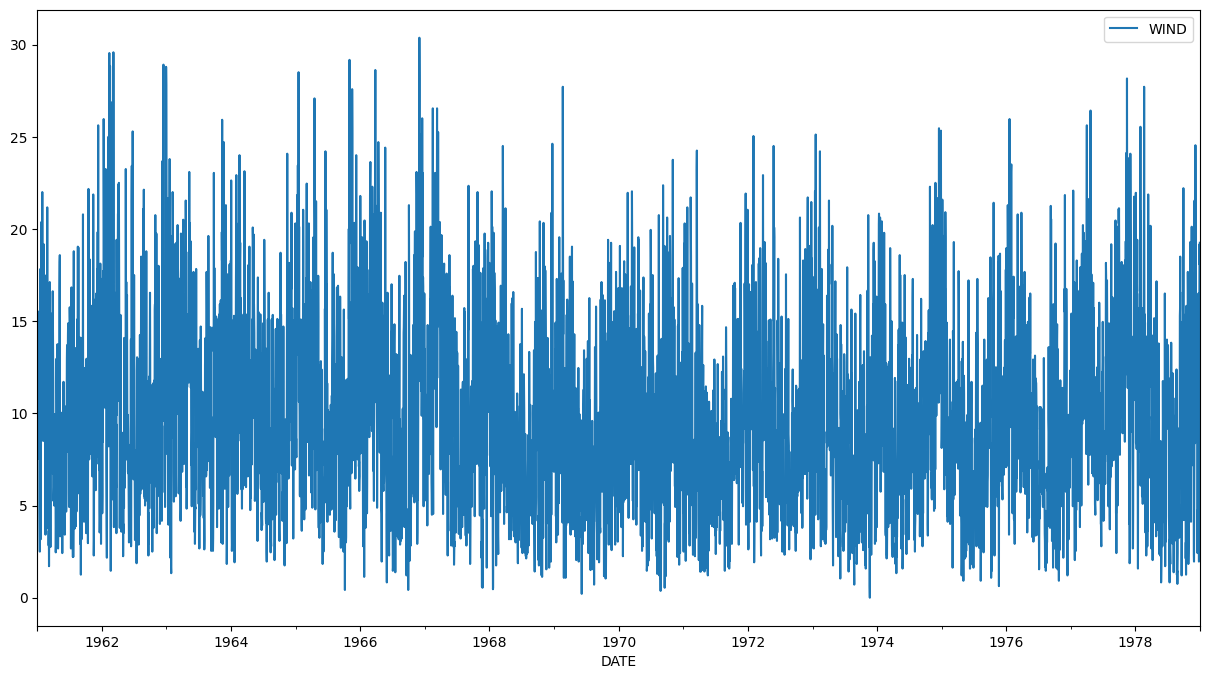

In [46]:
df.plot(x='DATE',y='WIND',figsize=(15,8))

<Axes: >

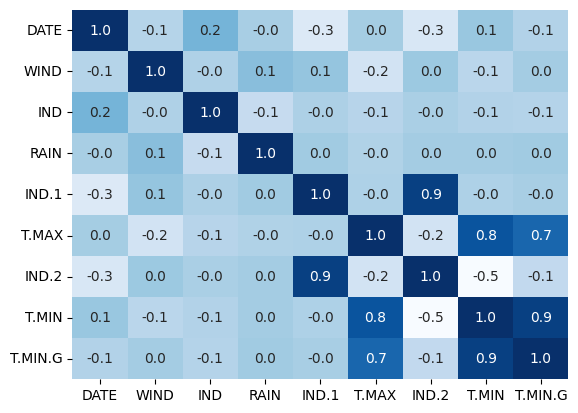

In [47]:
sns.heatmap(df.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

<Axes: ylabel='WIND'>

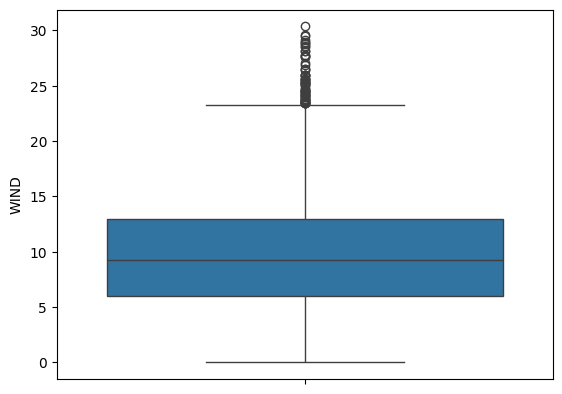

In [48]:
sns.boxplot(df['WIND'])

<Axes: ylabel='RAIN'>

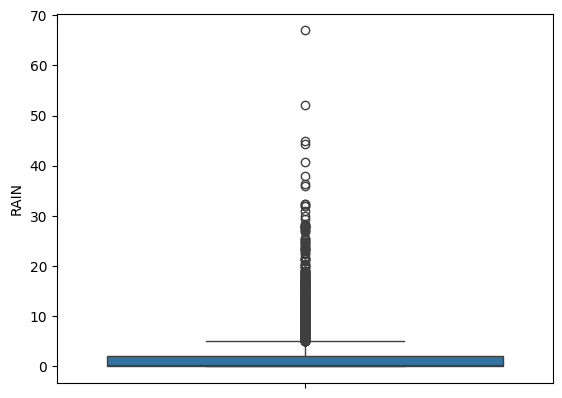

In [49]:
sns.boxplot(df['RAIN'])

<Axes: ylabel='T.MAX'>

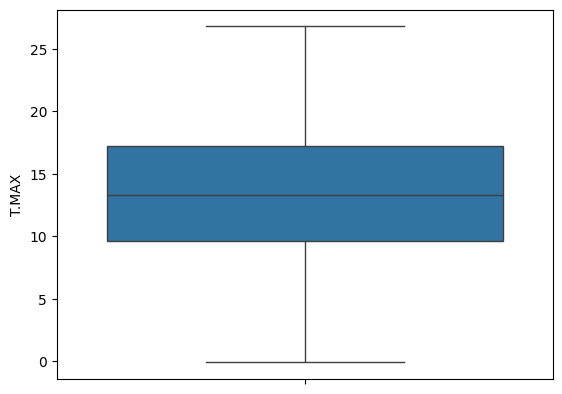

In [50]:
sns.boxplot(df['T.MAX'])

<Axes: ylabel='T.MIN'>

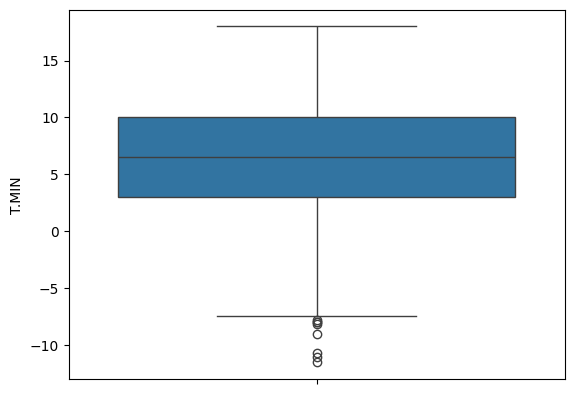

In [51]:
sns.boxplot(df['T.MIN'])

<Axes: ylabel='T.MIN.G'>

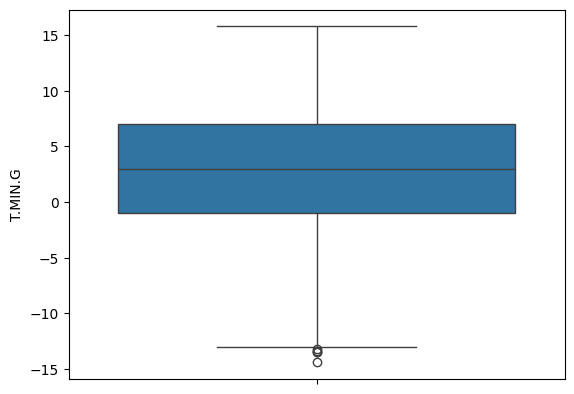

In [52]:
sns.boxplot(df['T.MIN.G'])

<Axes: xlabel='IND', ylabel='Count'>

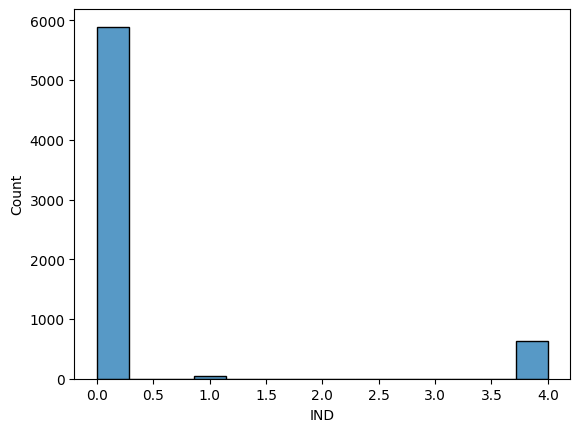

In [53]:
sns.histplot(df['IND'])

<Axes: xlabel='IND.1', ylabel='Count'>

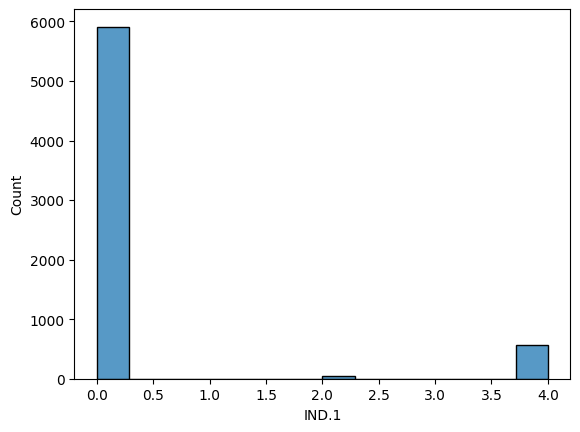

In [54]:
sns.histplot(df['IND.1'])

<Axes: xlabel='IND.2', ylabel='Count'>

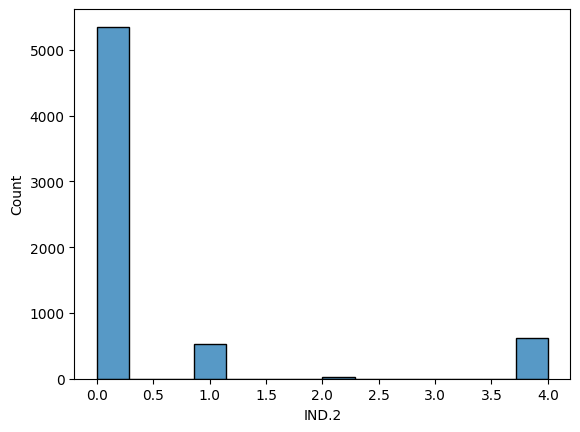

In [55]:
sns.histplot(df['IND.2'])

In [56]:
df = df.set_index('DATE')

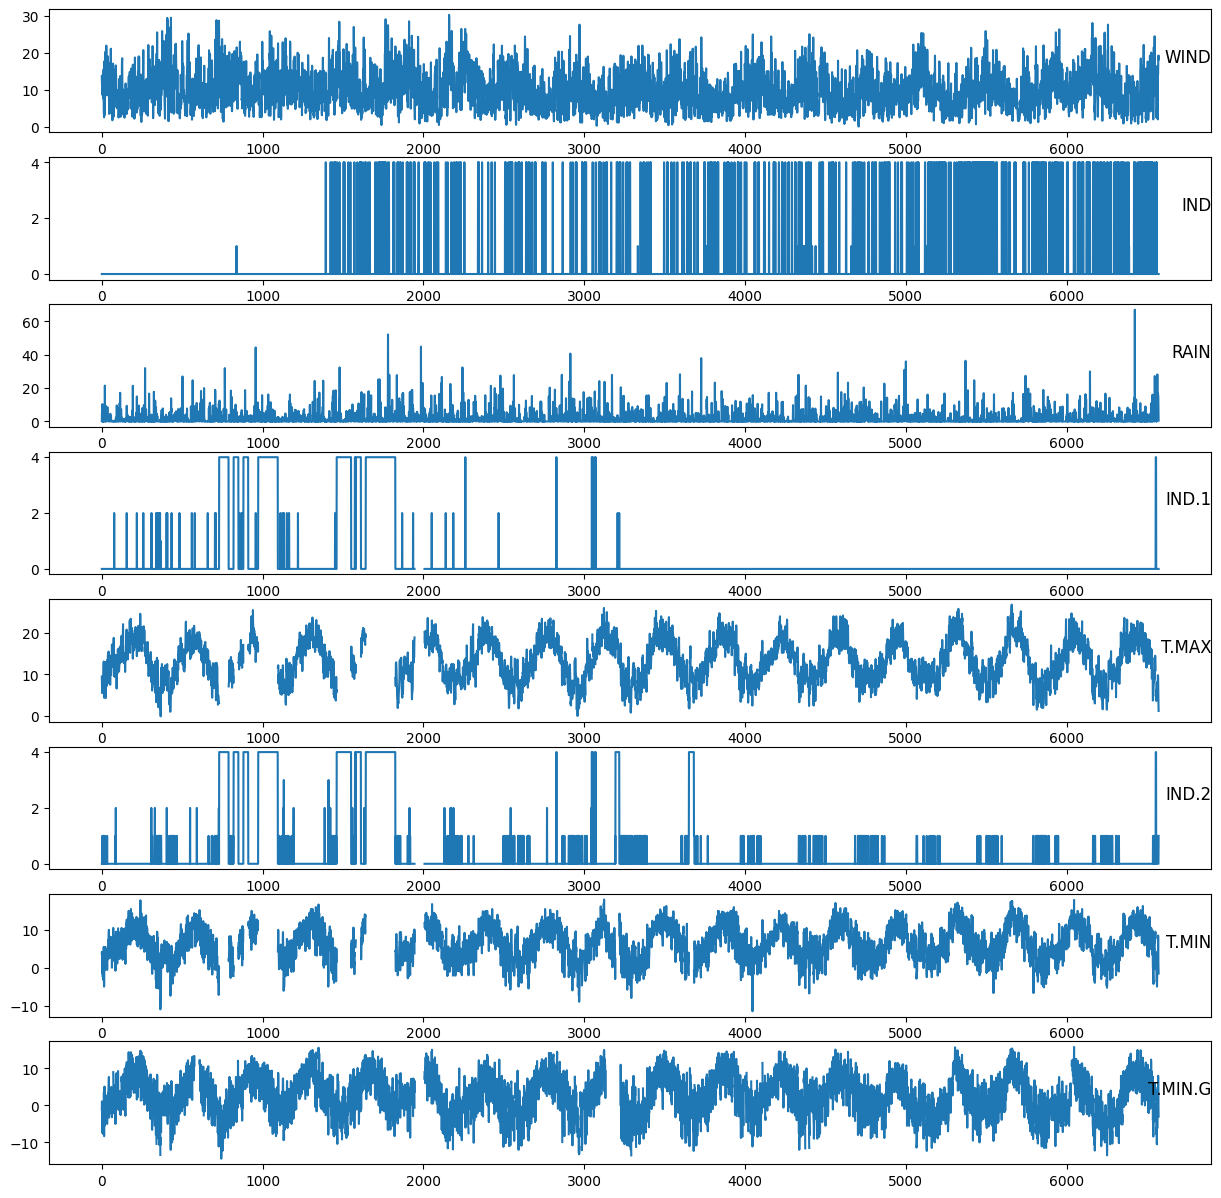

In [36]:
from matplotlib import pyplot
# load dataset
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3,4, 5, 6, 7]
i = 1
# plot each column
pyplot.figure(figsize=(15,15))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

## Preprocessing

### Cek Missing Value

In [57]:
print(df.isnull().sum())

WIND         0
IND          0
RAIN         0
IND.1       61
T.MAX      621
IND.2       61
T.MIN      674
T.MIN.G    360
dtype: int64


Terdapat missing value, maka akan kita tangani dengan imputasi menggunakan knn interpolasi

WIND       0
IND        0
RAIN       0
IND.1      0
T.MAX      0
IND.2      0
T.MIN      0
T.MIN.G    0
dtype: int64


<Axes: xlabel='DATE'>

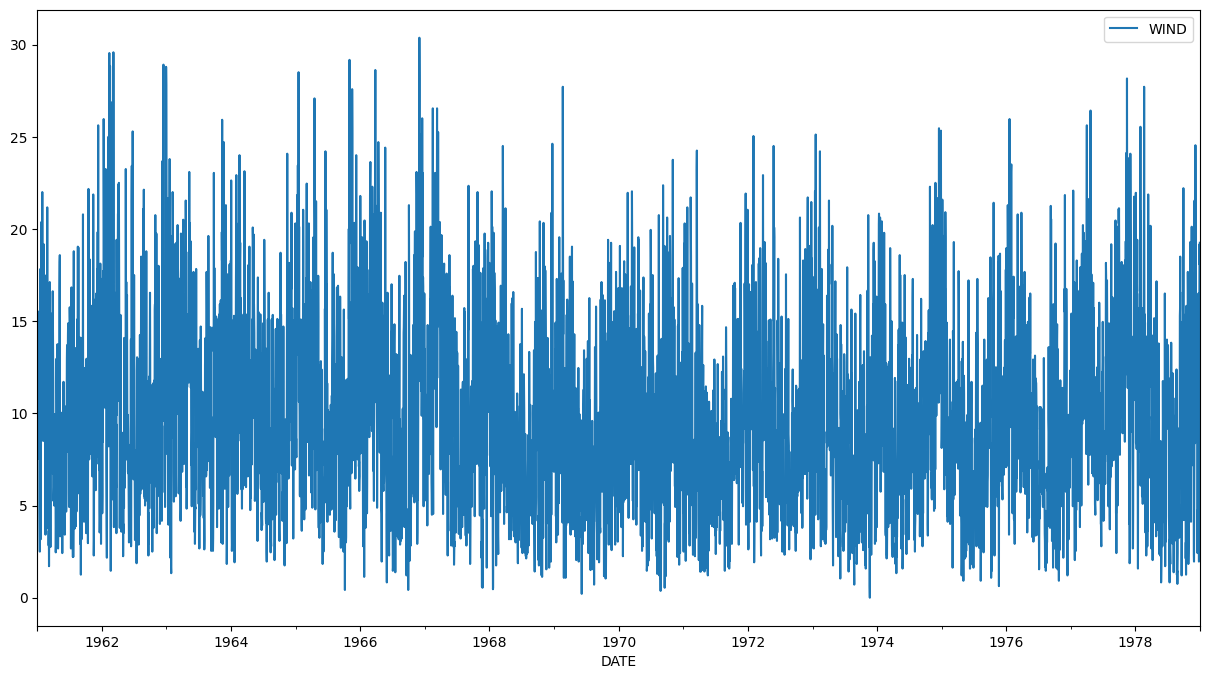

In [59]:
# More sophisticated imputation (e.g., using KNN, interpolation):

imputer = KNNImputer(n_neighbors=5) # Example with 5 neighbors
df[['WIND','RAIN','T.MAX','T.MIN','T.MIN.G','IND.1','IND.2']] = imputer.fit_transform(df[['WIND','RAIN','T.MAX','T.MIN','T.MIN.G','IND.1','IND.2']])

# Choose the imputation method that is appropriate for your data.
# After handling missing values, re-check for missing values
print(df.isnull().sum())

### Cek Outlier

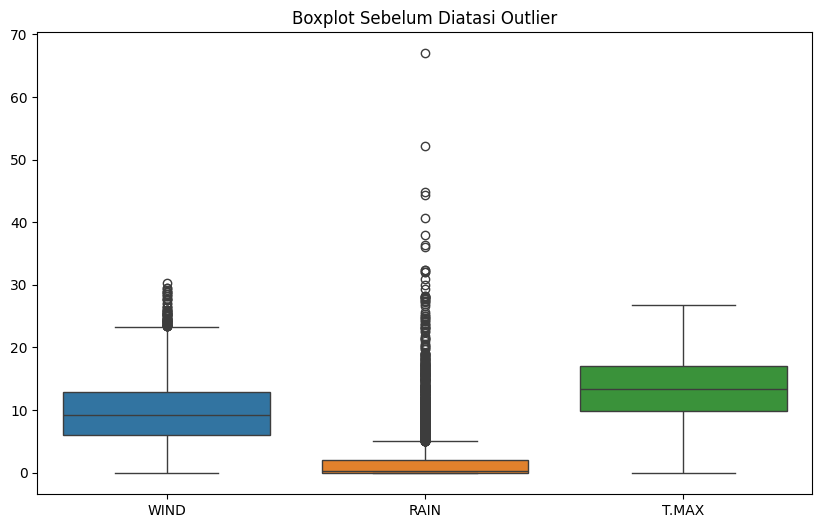

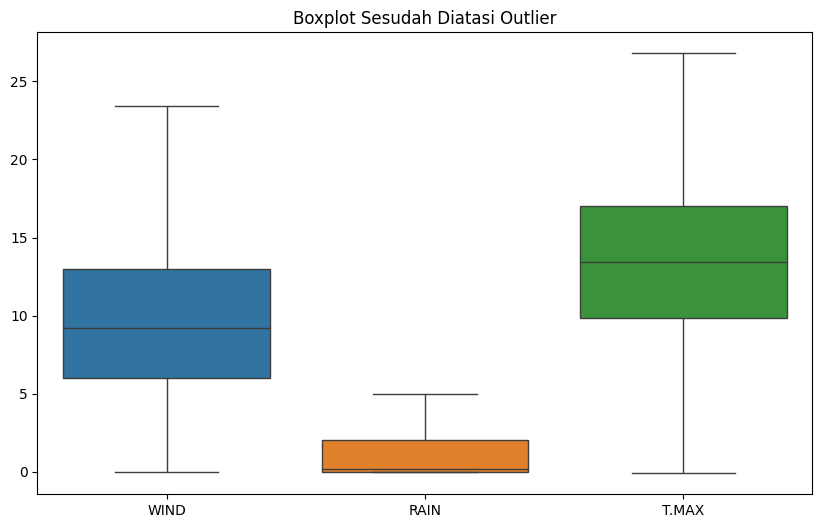

In [60]:
def handle_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower_bound, upper_bound)

    return df


#Visualisasi sebelum diatasi outliernya
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['WIND', 'RAIN', 'T.MAX']])
plt.title('Boxplot Sebelum Diatasi Outlier')
plt.show()

# Handling outliers for specified columns using IQR method
for col in ['WIND', 'RAIN', 'T.MAX', 'T.MIN', 'T.MIN.G', 'IND', 'IND.1', 'IND.2']:
  df = handle_outliers_iqr(df,col)

#Visualisasi setelah diatasi outliernya
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['WIND', 'RAIN', 'T.MAX']])
plt.title('Boxplot Sesudah Diatasi Outlier')
plt.show()

## Feature Engineering

jika ada data yang none kita isi dengan 0

In [61]:
df=df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6574 entries, 1961-01-01 to 1978-12-31
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   WIND     6574 non-null   float64
 1   IND      6574 non-null   int64  
 2   RAIN     6574 non-null   float64
 3   IND.1    6574 non-null   float64
 4   T.MAX    6574 non-null   float64
 5   IND.2    6574 non-null   float64
 6   T.MIN    6574 non-null   float64
 7   T.MIN.G  6574 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 462.2 KB


### Split Data

In [64]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Mengecek ukuran data yang dihasilkan
print(f"Data latih: {len(train_df)} baris")
print(f"Data uji: {len(test_df)} baris")


Data latih: 4601 baris
Data uji: 1973 baris


### Scaling data

Semua kolom dalam data frame memiliki skala yang berbeda. Sekarang kita akan mengubah skala nilai-nilai tersebut menjadi -1 hingga 1 untuk mempercepat pelatihan model.

In [65]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

### Sliding Window


Sekarang kita akan membuat sebuah fungsi yang menggunakan pendekatan sliding window untuk mengubah deret waktu menjadi sampel input berupa pengamatan masa lalu dan output berupa pengamatan masa depan agar dapat digunakan dalam algoritma pembelajaran terawasi (supervised learning).

In [66]:
def split_series(series, n_past, n_future):

  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

Asumsikan kita membutuhkan pengamatan selama 10 hari terakhir, agar dapat memprediksi pengamatan untuk 5 hari ke depan.

In [67]:
n_past = 10
n_future = 5
n_features = 8

Sekarang kita ubah data pelatihan dan pengujian menjadi sampel menggunakan fungsi split_series.

In [68]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

## Modeling

Kita akan membuat dua model dengan arsitektur seperti berikut :

- E1D1
n_features ==> no of features at each timestep in the data.

In [69]:
# E1D1

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

model_e1d1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10, 8)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 100), (None,   │         43,600 │ input_layer[0][0]      │
│                           │ 100), (None, 100)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 5, 100)         │              0 │ lstm[0][0]             │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 5, 100)         │         80,400 │ repeat_vector[0][0],   │
│                           │                        │                │ lstm[0][1], lstm[0][2] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 5, 8)           │            808 │ lstm_1[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 124,808 (487.53 KB)

 Trainable params: 124,808 (487.53 KB)

 Non-trainable params: 0 (0.00 B)

- E2D2 ==> Sequence to Sequence Model with two encoder layers and two decoder layers.

In [70]:
# E2D2

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)

model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

model_e2d2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 10, 8)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 10, 100),      │         43,600 │ input_layer_1[0][0]    │
│                           │ (None, 100), (None,    │                │                        │
│                           │ 100)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, 100), (None,   │         80,400 │ lstm_2[0][0]           │
│                           │ 100), (None, 100)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_1           │ (None, 5, 100)         │              0 │ lstm_3[0][0]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 5, 100)         │         80,400 │ repeat_vector_1[0][0], │
│                           │                        │                │ lstm_2[0][1],          │
│                           │                        │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 5, 100)         │         80,400 │ lstm_4[0][0],          │
│                           │                        │                │ lstm_3[0][1],          │
│                           │                        │                │ lstm_3[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, 5, 8)           │            808 │ lstm_5[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 285,608 (1.09 MB)

 Trainable params: 285,608 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

### Training Model

kita menggunakan Adam Optimixer dan Huber Loss sebagai loss function, setelah itu kita compile dan jalankan model.

In [71]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

### Prediksi pada test sample

In [72]:
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


### Inverse Scaling of the predicted values

Sekarang kita akan mengubah prediksi kembali ke skala aslinya.

In [73]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

## Checking Error

In [74]:
from sklearn.metrics import mean_absolute_error
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,6):
    print("Day ",j,":")
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred_e1d1[:,j-1,index]),end=", ")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred_e2d2[:,j-1,index]))
  print()
  print()

WIND
Day  1 :
MAE-E1D1 :  3.9523115240061024, MAE-E2D2 :  3.9548614059923373
Day  2 :
MAE-E1D1 :  3.9491412461588977, MAE-E2D2 :  3.9481968254334716
Day  3 :
MAE-E1D1 :  3.9428028059176126, MAE-E2D2 :  3.9407656526005717
Day  4 :
MAE-E1D1 :  3.94651489065033, MAE-E2D2 :  3.9446318509470384
Day  5 :
MAE-E1D1 :  3.9468816655554777, MAE-E2D2 :  3.944777126555665


IND
Day  1 :
MAE-E1D1 :  0.004092004954541076, MAE-E2D2 :  0.0016411597963618405
Day  2 :
MAE-E1D1 :  0.004435249498268973, MAE-E2D2 :  0.0014251897291238968
Day  3 :
MAE-E1D1 :  0.003352061697510568, MAE-E2D2 :  0.0018481134516417585
Day  4 :
MAE-E1D1 :  0.003749133023514682, MAE-E2D2 :  0.0016892577173029542
Day  5 :
MAE-E1D1 :  0.0047271582105440895, MAE-E2D2 :  0.0013230987931466213


RAIN
Day  1 :
MAE-E1D1 :  1.3508565231876266, MAE-E2D2 :  1.363322870539061
Day  2 :
MAE-E1D1 :  1.3483547721485996, MAE-E2D2 :  1.3647858170236236
Day  3 :
MAE-E1D1 :  1.345264879533866, MAE-E2D2 :  1.364048390713439
Day  4 :
MAE-E1D1 :  1.343

Dari output di atas, kita dapat mengamati bahwa, dalam beberapa kasus, model **E2D2** menunjukkan kinerja yang lebih baik dibandingkan model **E1D1** dengan kesalahan yang lebih kecil. Melatih berbagai model dengan jumlah lapisan bertumpuk yang berbeda dan membuat model ensemble juga memberikan hasil yang baik.